# Bike Sharing Time Series Analysis and Frocasting

Dataset: https://www.kaggle.com/datasets/hmavrodiev/london-bike-sharing-dataset

In this notebook I analyzed and visualized the time-series data, and trained a SARIMA model to forecast the hourly demand of a bike sharing system. 
To accomplish this, I followed these steps:
<ol>
    <li>Time Series Analysis</li>
    <ul>
        <li>Statopnarity KPSS test</li>
        <li>Seasonality decomposition</li>
        <li>Correlograms</li>       
    </ul>
    <li>Forecasting</li>
    <ul>
        <li>Baseline model</li>
        <li>Daily seasonality</li>
        <li>SARIMA parameters tuning</li>
        <li>SARIMA</li>
    </ul>
</ol>

**I trained the SARIMA model on 6 months of data and achieved a 1% MAPE for forecasting the week.**
The model could be enhanced by adding holidays and weekends into the training subset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [2]:
bike = pd.read_csv('london_merged.csv')

In [3]:
bike.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
bike.timestamp = pd.to_datetime(bike.timestamp)

## 1. Time Series Analysis

For the overal analysis let's group data by date

In [5]:
bike['date'] = bike['timestamp'].dt.date
bike['date'] = pd.to_datetime(bike['date'])

In [6]:
cnt_per_date = bike.groupby(by='date').cnt.sum()

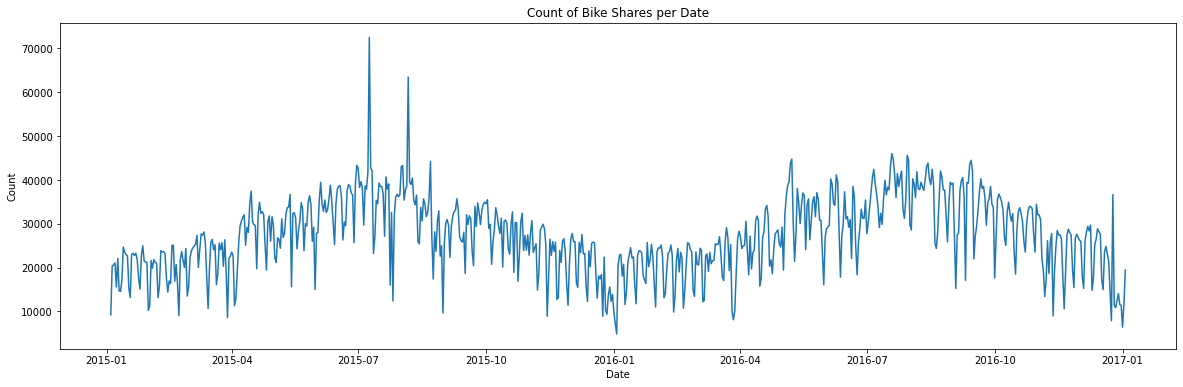

In [7]:
plt.figure(figsize=(20, 6))

plt.title('Count of Bike Shares per Date')

plt.plot(cnt_per_date.index, cnt_per_date)
plt.xlabel('Date')
plt.ylabel('Count')

plt.show()

### 1.1 Statopnarity KPSS test 

In [8]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [9]:
kpss_test(cnt_per_date)

Results of KPSS Test:
Test Statistic            0.369400
p-value                   0.090345
Lags Used                15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


The timeseries is stationary 

### 1.2 STL decomposition
For the practical reasons let's visualize only part of our data

In [10]:
decomposed = seasonal_decompose(cnt_per_date['2016-06-01':], model='additive', period = 30)
weekly_decomposed = seasonal_decompose(cnt_per_date['2016-06-01':], model='additive', period = 7)

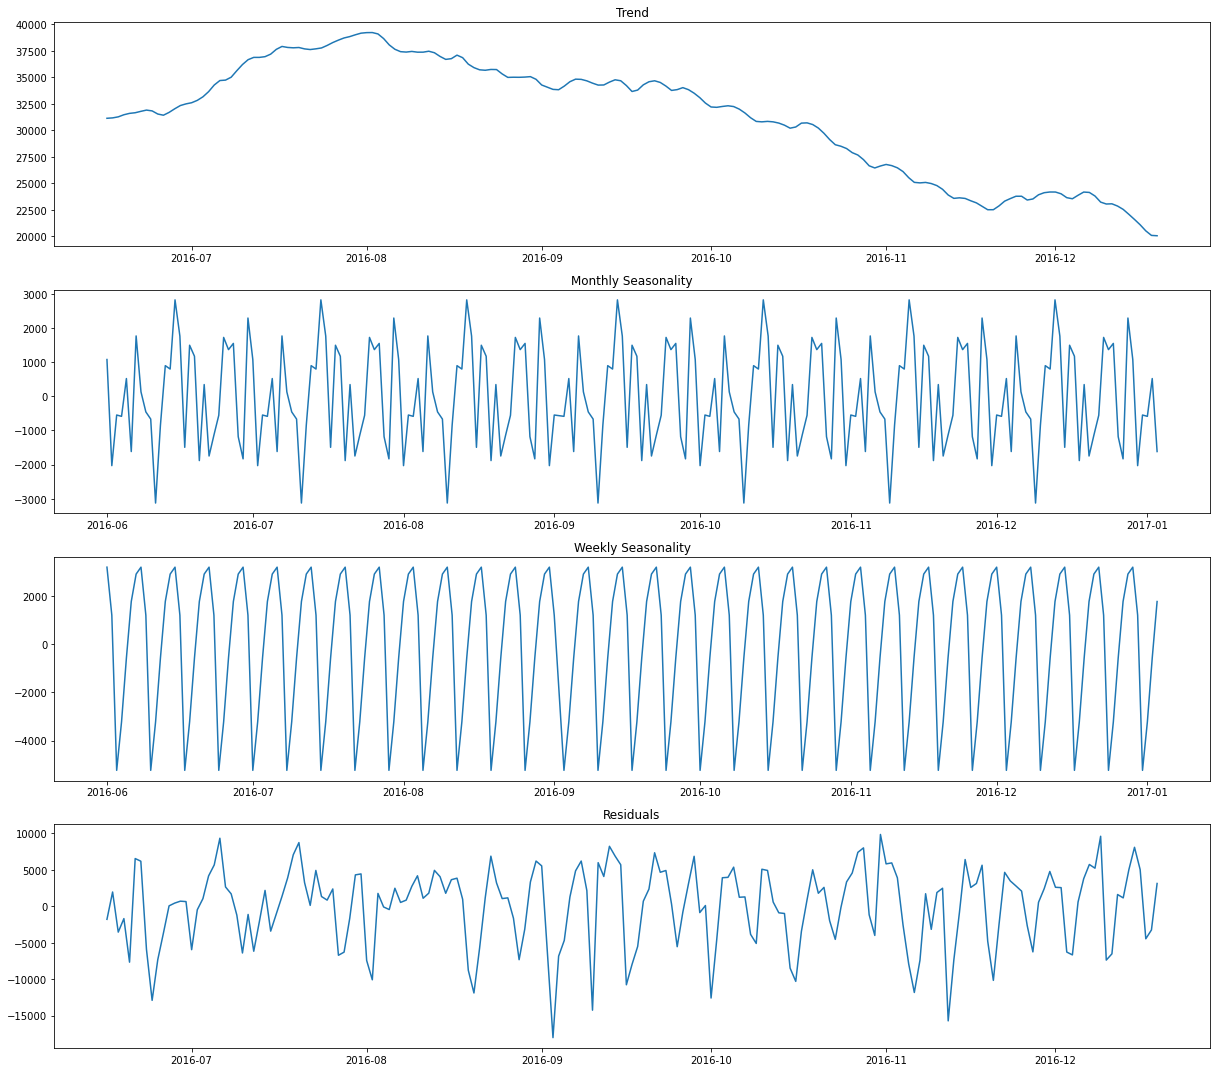

In [11]:
plt.figure(figsize=(17, 15))

plt.subplot(411)
plt.plot(cnt_per_date['2016-06-01':].index, decomposed.trend)
plt.title('Trend')

plt.subplot(412)
plt.plot(cnt_per_date['2016-06-01':].index, decomposed.seasonal)
plt.title('Monthly Seasonality')

plt.subplot(413)
plt.plot(cnt_per_date['2016-06-01':].index, weekly_decomposed.seasonal)
plt.title('Weekly Seasonality')

plt.subplot(414)
plt.plot(cnt_per_date['2016-06-01':].index, decomposed.resid)
plt.title('Residuals')

plt.tight_layout()

According to the graphs there is monthly and weekly seasonality

### 1.3 Correlograms

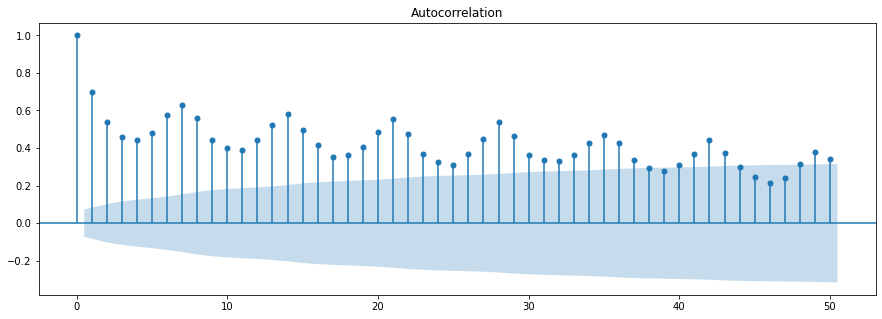

In [12]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
fig = plot_acf(cnt_per_date, ax=ax, lags = 50)
plt.show()

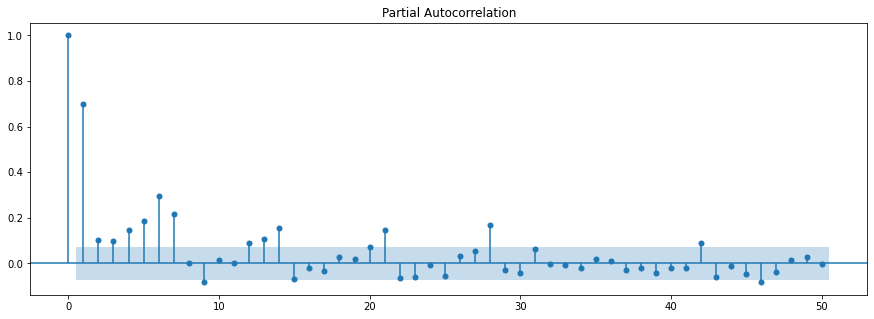

In [13]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
fig = plot_pacf(cnt_per_date, ax=ax, lags = 50)
plt.show()

## 2. Forecasting

We will use hourly data.
To predict the last week we will train model on last 6 month to avoid overfitting.

In [14]:
cnt_per_hour = bike[['timestamp', 'cnt']].set_index('timestamp')

In [15]:
test_size = 24*7
train_size = 24*30*6
test = cnt_per_hour.tail(test_size)
train = cnt_per_hour.tail(train_size+test_size).head(train_size)

### 2.1 Baseline model
We will use mean of the trained data as a baseline

In [16]:
train_mean = np.array([train.mean()]*test_size)

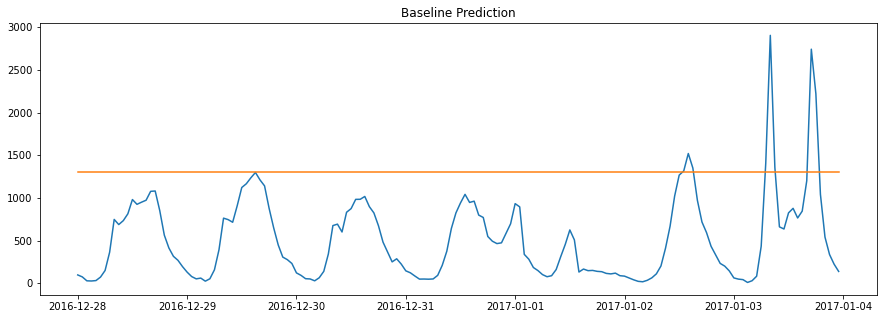

In [17]:
plt.figure(figsize=(15,5))
plt.title('Baseline Prediction')

plt.plot(test.index, test, label='test')
plt.plot(test.index, train_mean, label='mean')

plt.show()

In [18]:
mse = MSE(test, train_mean)
mape = MAPE(test, train_mean)
print('MSE = {}; MAPE = {}'.format(mse, mape))

MSE = 847003.9612546237; MAPE = 8.682373301236655


### 2.2 Daily seasonality

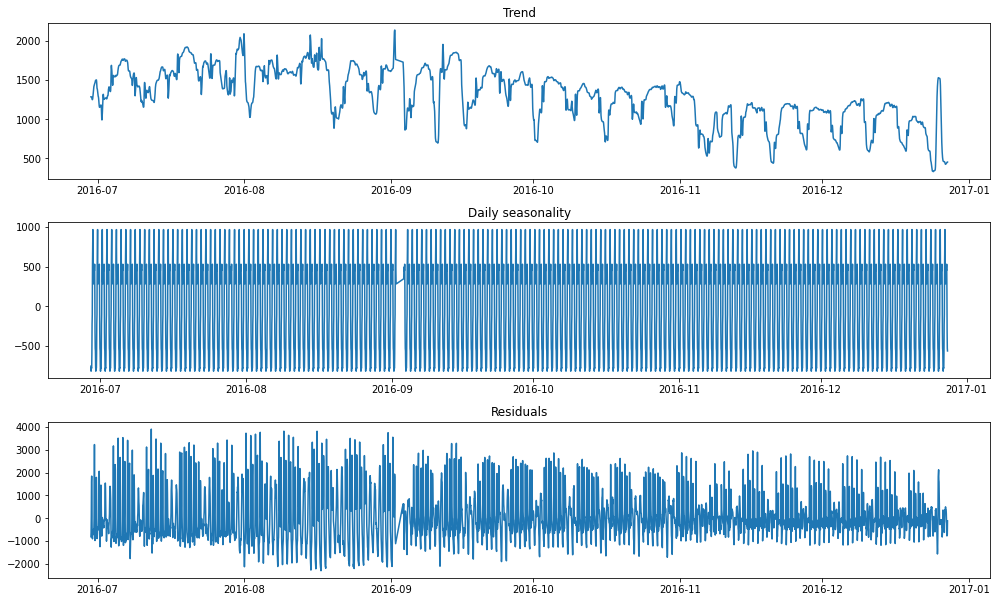

In [19]:
decomposed = seasonal_decompose(train.cnt.values, freq=24)

plt.figure(figsize=(14, 11))

plt.subplot(411)
plt.plot(train.index, decomposed.trend)
plt.title('Trend')

plt.subplot(412)
plt.plot(train.index, decomposed.seasonal)
plt.title('Daily seasonality')

plt.subplot(413)
plt.plot(train.index, decomposed.resid)
plt.title('Residuals')

plt.tight_layout()

As we can see data exhibits daily seasonality.

### 2.2 SARIMA parameters tuning

In [20]:
kpss_test(train)

Results of KPSS Test:
Test Statistic            8.86894
p-value                   0.01000
Lags Used                20.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


The train subset is not stationary, so we need to differentiate the time series to remove trend and seasonality

In [21]:
diff = train.values[1:] - train.values[:-1] 
diff = diff[(24*30):] - diff[:(-24*30)]
diff = diff[(24*7):] - diff[:(-24*7)]
diff = diff[(24):] - diff[:(-24)]

In [22]:
kpss_test(diff)

Results of KPSS Test:
Test Statistic             0.015447
p-value                    0.100000
Lags Used                105.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


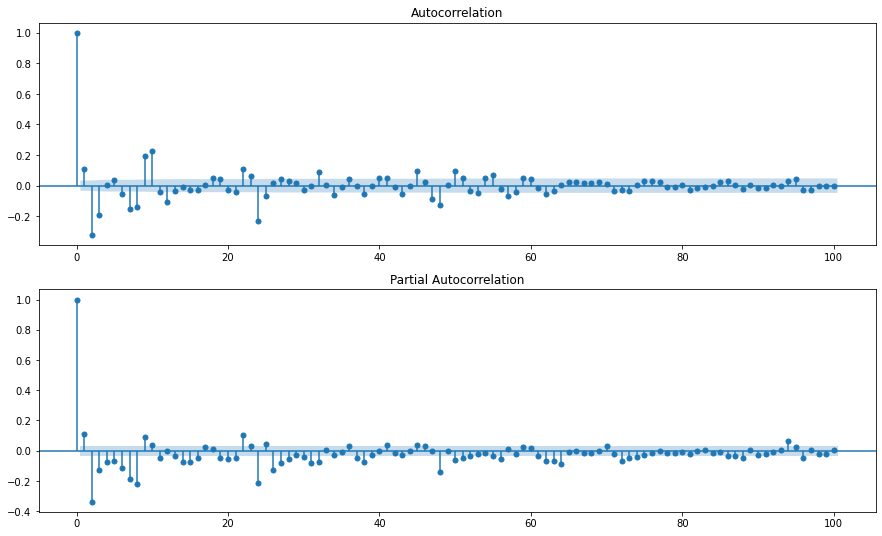

In [23]:
fig = plt.figure(figsize=(15, 9))

ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, lags=100, ax=ax)
ax = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=100, ax=ax)

plt.show()

In [24]:
%%time
res = sm.tsa.arma_order_select_ic(train, max_ar=6, max_ma=6, ic='aic') #diff
print('ARMA(p,q) =',res['aic_min_order'],'is the best')

ARMA(p,q) = (6, 5) is the best
Wall time: 1min 34s


### 2.3 SARIMA

In [26]:
%%time
param = (6, 1, 5)
param_seasonal = (6, 1, 5, 24)
sarima = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
sarima.summary()

Wall time: 1h 3min 44s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                cnt   No. Observations:                 4320
Model:             SARIMAX(6, 1, 5)x(6, 1, 5, 24)   Log Likelihood              -31502.248
Date:                            Mon, 27 Feb 2023   AIC                          63050.495
Time:                                    15:29:41   BIC                          63196.895
Sample:                                         0   HQIC                         63102.203
                                           - 4320                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0412      0.042     -0.974      0.330      -0.124       0.042
ar.L2         -0.7586      0.041    -18.429      0.000      -0.839      -0.678
ar.L3          0.1670      0.038      4.368      0.000       0.092       0.242
ar.L4         -0.2947      0.040     -7.313      0.000      -0.374      -0.216
ar.L5          0.5205      0.033     15.897      0.000       0.456       0.585
ar.L6         -0.1103      0.028     -3.957      0.000      -0.165      -0.056
ma.L1          0.0741      0.041      1.820      0.069      -0.006       0.154
ma.L2          0.3570      0.041      8.679      0.000       0.276       0.438
ma.L3         -0.5470      0.033    -16.760      0.000      -0.611      -0.483
ma.L4         -0.1045      0.039     -2.647      0.008      -0.182      -0.027
ma.L5         -0.7743      0.038    -20.467      0.000      -0.848      -0.700
ar.S.L24      -0.3423      0.151     -2.263      0.024      -0.639      -0.046
ar.S.L48      -0.7939      0.088     -8.981      0.000      -0.967      -0.621
ar.S.L72      -0.4643      0.168     -2.769      0.006      -0.793      -0.136
ar.S.L96      -0.5228      0.077     -6.781      0.000      -0.674      -0.372
ar.S.L120     -0.6409      0.094     -6.803      0.000      -0.826      -0.456
ar.S.L144     -0.3009      0.044     -6.909      0.000      -0.386      -0.216
ma.S.L24       0.0118      0.152      0.077      0.938      -0.287       0.311
ma.S.L48       0.4296      0.135      3.189      0.001       0.166       0.694
ma.S.L72       0.0532      0.159      0.334      0.739      -0.259       0.366
ma.S.L96       0.0694      0.110      0.634      0.526      -0.145       0.284
ma.S.L120      0.1821      0.075      2.433      0.015       0.035       0.329
sigma2      2.092e+05   3379.070     61.915      0.000    2.03e+05    2.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             38818.48
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
preds = sarima.predict(start=train_size, end=train_size+test_size-1, dynamic=True)

In [31]:
mse = MSE(test, preds)
mape = MAPE(test, preds)
print('MSE = {}; MAPE = {}'.format(mse, mape))

MSE = 285323.0625780938; MAPE = 1.0357659900138592


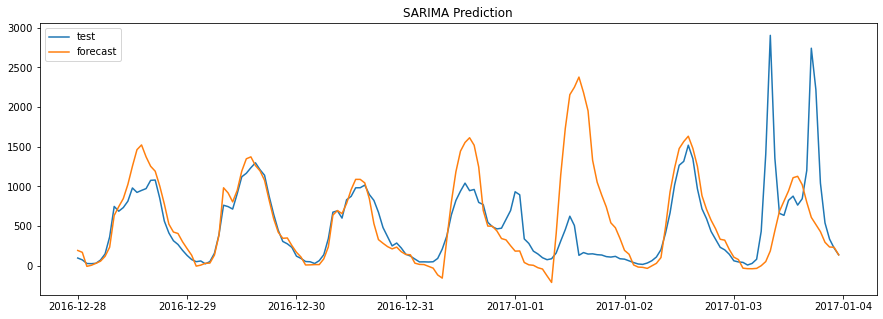

In [49]:
fig = plt.figure(figsize=(15,5))
plt.title('SARIMA Prediction')

plt.plot(test.index, test, label='test')
plt.plot(test.index, preds, label='forecast')
plt.legend()

plt.show()

**The model demonstrates good performance, with a 7% lower MAPE than the baseline. However, it was unable to accurately predict demand on the first day of the New Year. To further enhance the model's accuracy, we can add exogenous variables (such as holidays and weekends) into the training subset.**